In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql.functions import col

In [2]:
spark = SparkSession.builder.appName('EnergyConsumption').getOrCreate()
sc = spark.sparkContext

21/10/13 10:03:26 WARN Utils: Your hostname, Stijns-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.120 instead (on interface en0)
21/10/13 10:03:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/13 10:03:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
df_electricity_production = spark.read.option("header","true").option("inferSchema", "true").csv("./data/Elektriciteit__aanbod_en_verbruik_12102021_102309.csv", sep=";")
electricity_production_raw = sc.textFile("./data/Elektriciteit__aanbod_en_verbruik_12102021_102309.csv")

In [4]:
df_electricity_production.show()
df_electricity_production.printSchema()
electricity_production_raw.first()

21/10/13 10:03:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------------------------+---------------------------------------------+-------------------------------------------------+-------------------------------------+-----------------------------------------------------------+--------------------------------------------+----------------------------------------------------+----------------------------------------------+-----------------------------------------------+-------------------------------------------------------------------------------+-------------------------------------+---------------------------------------------------------+---------------------------------------------------------+--------------------------------------------------------+-------------------------------------+-----------------------------------------+-------------------------------+-----------------------+---------------------------+--------------------------+------------------------------------+--------------------------+-------------------------------

'"Perioden";"Bruto productie (mln kWh)";"Eigen verbruik bij elektr.productie (mln kWh)";"Netto productie/Netto productie, totaal (mln kWh)";"Netto productie/Kernenergie (mln kWh)";"Netto productie/Brandstoffen/Brandstoffen, totaal (mln kWh)";"Netto productie/Brandstoffen/Kolen (mln kWh)";"Netto productie/Brandstoffen/Olieproducten (mln kWh)";"Netto productie/Brandstoffen/Aardgas (mln kWh)";"Netto productie/Brandstoffen/Biomassa (mln kWh)";"Netto productie/Brandstoffen/Overige brandstoffen (niet-hernieuwbaar) (mln kWh)";"Netto productie/Waterkracht (mln kWh)";"Netto productie/Windenergie/Windenergie, totaal (mln kWh)";"Netto productie/Windenergie/Windenergie op land (mln kWh)";"Netto productie/Windenergie/Windenergie op zee (mln kWh)";"Netto productie/Zonnestroom (mln kWh)";"Netto productie/Overige bronnen (mln kWh)";"Invoer/Invoer, totaal (mln kWh)";"Invoer/België (mln kWh)";"Invoer/Denemarken (mln kWh)";"Invoer/Duitsland (mln kWh)";"Invoer/Verenigd Koninkrijk (mln kWh)";"Invoer/Noorwe

In [5]:
# Load a text file and convert each line to a Row, so that a DataFrame can be made.

electricity_production_parts = electricity_production_raw.map(lambda l: l.split(";"))
electricity_production_rows = electricity_production_parts.map(lambda l: Row(periode=l[0], netto_productie=l[3],
                                                                             netto_productie_brandstoffen=l[5],
                                                                             netto_productie_windenergie=l[12],
                                                                             netto_productie_zonnestroom=l[15]))

In [6]:
electricity_production_rows.take(2)


[Row(periode='"Perioden"', netto_productie='"Netto productie/Netto productie, totaal (mln kWh)"', netto_productie_brandstoffen='"Netto productie/Brandstoffen/Brandstoffen, totaal (mln kWh)"', netto_productie_windenergie='"Netto productie/Windenergie/Windenergie, totaal (mln kWh)"', netto_productie_zonnestroom='"Netto productie/Zonnestroom (mln kWh)"'),
 Row(periode='"2013"', netto_productie='97370', netto_productie_brandstoffen='', netto_productie_windenergie='5627', netto_productie_zonnestroom='410')]

In [7]:

header = electricity_production_rows.first()
df_electricity_production = spark.createDataFrame(electricity_production_rows.filter(lambda row: row != header))

In [8]:
df_electricity_production.show()

df2_electricity_production = df_electricity_production.selectExpr("cast(periode as string) periode",
                                                                  "cast(netto_productie as int) netto_productie",
                                                                  "cast(netto_productie_brandstoffen as int) netto_productie_brandstoffen",
                                                                  "cast(netto_productie_windenergie as int) netto_productie_windenergie",
                                                                  "cast(netto_productie_zonnestroom as int) netto_productie_zonnestroom")
df2_electricity_production.printSchema()

+--------+---------------+----------------------------+---------------------------+---------------------------+
| periode|netto_productie|netto_productie_brandstoffen|netto_productie_windenergie|netto_productie_zonnestroom|
+--------+---------------+----------------------------+---------------------------+---------------------------+
|  "2013"|          97370|                            |                       5627|                        410|
|  "2014"|          99310|                            |                       5797|                        725|
|  "2015"|         105902|                       91907|                       7550|                       1109|
|  "2016"|         111032|                       96122|                       8170|                       1602|
|  "2017"|         113465|                       95895|                      10569|                       2204|
|  "2018"|         110692|                       92429|                      10549|                     

In [9]:
df_pandas_electricity_production = df2_electricity_production.toPandas()
print(df_pandas_electricity_production)

    periode  netto_productie  netto_productie_brandstoffen  \
0    "2013"            97370                           NaN   
1    "2014"            99310                           NaN   
2    "2015"           105902                       91907.0   
3    "2016"           111032                       96122.0   
4    "2017"           113465                       95895.0   
5    "2018"           110692                       92429.0   
6  "2019**"           117572                       96460.0   
7  "2020**"           119238                       91383.0   

   netto_productie_windenergie  netto_productie_zonnestroom  
0                         5627                          410  
1                         5797                          725  
2                         7550                         1109  
3                         8170                         1602  
4                        10569                         2204  
5                        10549                         3709  
6      

<AxesSubplot:xlabel='periode'>

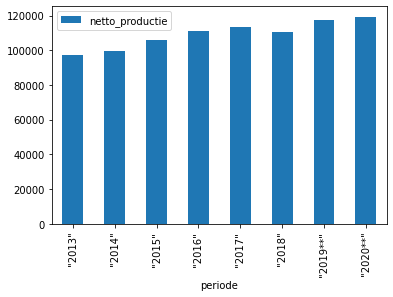

In [10]:
df_pandas_electricity_production.plot(x="periode", y="netto_productie", kind="bar")
